# Abstract

- **Data Cleaning**: find out the outfitters for both `Signals` and `ClosePrice`, and use linear interpolate to correct.
- **Signal Embedding**: this is time-series dataset, we can use embeeding method to build more reliable new features. Note that `Signal` cannot be used for corresponding `ClosePrice` prediction, need to do extra shift.
- **Feature Importance**: look into the correlation between embedding signals and `ClosePrice`. 

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
data = pd.read_excel("ResearchDatasetV2.0.xlsx")

In [3]:
data.head()

,Date,Signal,ClosePrice
0,20120103,3.107767,127.495
1,20120104,3.107282,127.700
2,20120105,3.099757,128.040
3,20120106,3.134223,127.710
4,20120109,3.135922,128.020


## Data Cleaning

,Date,Signal,ClosePrice
303,20130326,-3.802670,156.1900
421,20130912,4.193204,618.9500
422,20130913,4.143689,619.3300
423,20130916,4.124515,710.3100
459,20131105,429.514563,176.2700
460,20131106,432.961165,177.1700
570,20140414,0.004560,182.9401
571,20140415,0.454976,184.2000
572,20140416,0.455898,186.1250


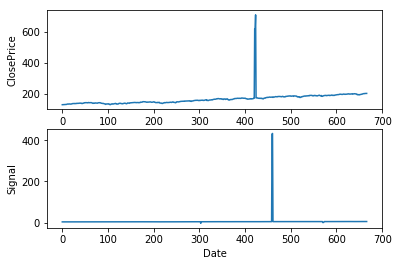

In [4]:
# Simple Visualization & Error Detection

plt.subplot(2, 1, 1)
plt.plot(data["ClosePrice"])
plt.ylabel("ClosePrice")

plt.subplot(2, 1, 2)
plt.plot(data["Signal"])
plt.ylabel("Signal")

plt.xlabel("Date")

price_error_index = data[data["ClosePrice"] > 300].index
signal_error_index = data[~data["Signal"].between(2, 10)].index
data.loc[price_error_index.union(signal_error_index)]

Text(0.5,0,'Date')

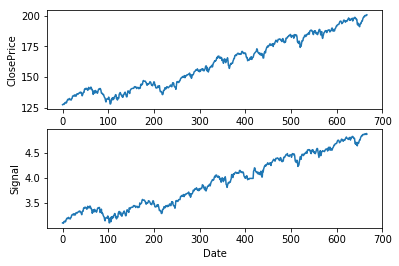

In [5]:
# Data Cleaning
# Use Linear interpolate method to correct error points

data.loc[price_error_index, "ClosePrice"] = np.nan
data["ClosePrice"] = data["ClosePrice"].interpolate()

data.loc[signal_error_index, "Signal"] = np.nan
data["Signal"] = data["Signal"].interpolate()

# Check Cleaned Data
plt.subplot(2, 1, 1)
plt.plot(data["ClosePrice"])
plt.ylabel("ClosePrice")

plt.subplot(2, 1, 2)
plt.plot(data["Signal"])
plt.ylabel("Signal")

plt.xlabel("Date")

## Embedding Signal & Importance

Because the “signal” in the table is received at the end of the day, we will make embedding singals for (1, 3, 5, 10) days to check the predictive power.

Text(0.5,0,'Signal_10')

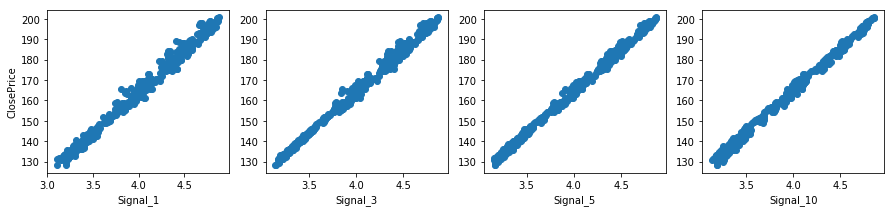

In [6]:
# Embedding Signal

data["Signal_1"] = data["Signal"].shift(1)
data["Signal_3"] = data["Signal_1"].rolling(window=3).mean()
data["Signal_5"] = data["Signal_1"].rolling(window=5).mean()
data["Signal_10"] = data["Signal_1"].rolling(window=10).mean()

# Drop first 10 row for consistency
data = data.iloc[10:]

# Scatter plot for each embedding signal
plt.figure(figsize=(15,3))

plt.subplot(1,4,1)
plt.scatter(data["Signal_1"], data["ClosePrice"])
plt.xlabel("Signal_1")
plt.ylabel("ClosePrice")

plt.subplot(1,4,2)
plt.scatter(data["Signal_3"], data["ClosePrice"])
plt.xlabel("Signal_3")

plt.subplot(1,4,3)
plt.scatter(data["Signal_5"], data["ClosePrice"])
plt.xlabel("Signal_5")

plt.subplot(1,4,4)
plt.scatter(data["Signal_10"], data["ClosePrice"])
plt.xlabel("Signal_10")

According to the scatter plots, we can roughly see that "Signal_5" and "Signal_10" have stronger relationship with "ClosePrice" than "Signal_1" and "Signal_3". Now let's look into the correlation coefficient for each embedding signal.

In [7]:
data.corr()[["ClosePrice"]].loc[["Signal_1", "Signal_3", "Signal_5", "Signal_10"]]

,ClosePrice
Signal_1,0.996018
Signal_3,0.997707
Signal_5,0.998454
Signal_10,0.998007


"Signal_5" has the strongest correlationship with "ClosePrice"

# Summary

- **Viability**: According to the correlation plot and the correaltion coefficient, we can tell the `Signal` has very strong positive correlation with `ClosePrice` thus great predictive power. However, we need to do more feature engineering work to gain better predictive result, for example, can use time-series weighting average to do embedding, can try more embedding window size to find the best.

- **Shortcomings**: Intuitively, the `signal` is a combination of multiple features `[f1, f2, ..., fn]`. Although the `signal` has very ideal predictive power and the analysis turns out we can easily build a linear model to predict the `ClosePrice`, this might be a problem if we want to make a probabilistic prediction instead of point estimation. Since when doing portfolio investment, we can use probabilities to manage ratio and hedging. The orinal multiple features [f1, f2, ..., fn] probably hold mnore information while combination will lose it. Meanwhile, using too much embedding signals by same signal could lead to `multicollinearity` problem.

- **TODO**: We can use XGBoost package to gather more information about the signal predictive power. Can use cross validation to build a model to test.

- **Recommendation**: As I state in the `Shortcomings`, building portfolio need probabilistic prediction instead of point estimation. So it probably a great idea to build a stochastic porcess model, we can look into the distribution of `ClosePrice_Change`. If there is enough datasize, we can also adopt RNN framework to do prediction.